# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

In [20]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [21]:
source = 'Co60'
path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'

data = np.load(path)
pulsos_practica_master = data['data']

In [22]:
from functions import gauss, gauss_fit, momentos, pulso, get_mean_pulse_from_set, delay_pulse_pair, create_and_delay_pulse_pair, move_to_reference, pulso_escalon, pulso_sigmoid, create_position
from Models import model_definition

# **INTERPOLATION**

In [23]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind = 'cubic', axis = 1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind = 'cubic', axis = 1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind = 'cubic', axis = 1)
new_V82 = interp_func_V82(tiempo_new)

interp_func_practica = interp1d(tiempo,pulsos_practica_master, kind = 'cubic', axis = 1)
new_pulsos_practica = interp_func_practica(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

#----------------------------------------------------- Print important information -----------------------------------
print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **GENERATE MEAN PULSE PER DETECTOR**

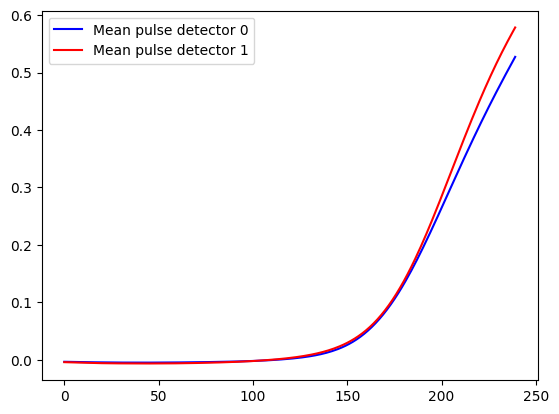

In [24]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **PREPROCESSING**

In [25]:
Num_casos = 0
Nc = 2

t_shift = 8 #In time steps
t = np.linspace(0, Nt, Nt_new)
#t0 = 550 + np.random.randint(100, size = Num_casos)
t0 = 65 + np.random.randint(10, size = Num_casos)

In [26]:
#------------------------------------- Define size of train set from datos practica ---------------------------------
Ntrain_practica = int(1*new_pulsos_practica.shape[0])
Ntest_practica = int(0.0*new_pulsos_practica.shape[0])
print('Número de casos de entrenamiento de la práctica: ', Ntrain_practica)
print('Número de casos de Test de la práctica: ', Ntest_practica)

Número de casos de entrenamiento de la práctica:  2211
Número de casos de Test de la práctica:  0


In [27]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 20
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 15
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0.5, 1.0, 'Detector 1')

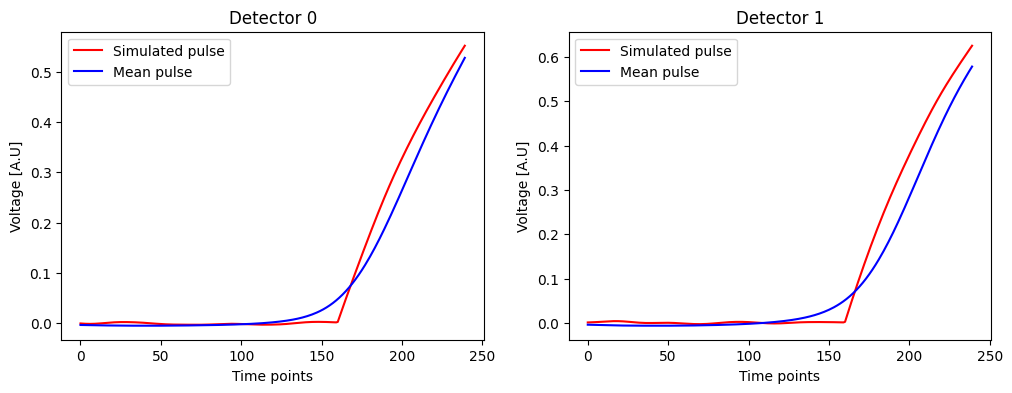

In [28]:
#pulso_original_dec0 = pulso_escalon(t, 550, A = 0.6)
#pulso_original_dec1 = pulso_escalon(t, 550, A = 0.6)
#pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
#pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)



plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 0')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')
plt.title('Detector 1')

In [29]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Num_casos, Nt_new))
INPUT_dec1 = np.zeros((Num_casos, Nt_new))

for i in range(Num_casos):
  #PULSO_dec0 = pulso_escalon(t, t0[i], A = 0.6)
  #PULSO_dec1 = pulso_escalon(t, t0[i], A = 0.6)
  PULSO_dec0 = pulso(t, t0[i], tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)
  PULSO_dec1 = pulso(t, t0[i], tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1

In [30]:
#-------------------------------- Delay simulated pulses --------------------------------------------

#delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, np.expand_dims(INPUT_dec0, axis = -1), start = start, stop = stop, max_delay = 240, channel = 0)
#delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, np.expand_dims(INPUT_dec1, axis = -1), start = start, stop = stop, max_delay = 240, channel = 0)
#INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = 32, NOISE = True)
#INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0[:,start:stop], new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1[:,start:stop], new_time_step, delay_steps = 32, NOISE = True)



#--------------------------------- Move rest of the pulses to align with mean and then delay them ---------------------------------------

#delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
#delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 1)
#INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, delay_steps = 32, NOISE = True)
#INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,0], new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practica,start:stop,1], new_time_step, delay_steps = 32, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0, INPUT2_dec0), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1, INPUT2_dec1), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0, REF2_dec0))
REF_train_dec1 = np.concatenate((REF_dec1, REF2_dec1))

Text(0.5, 1.0, 'Detector 1')

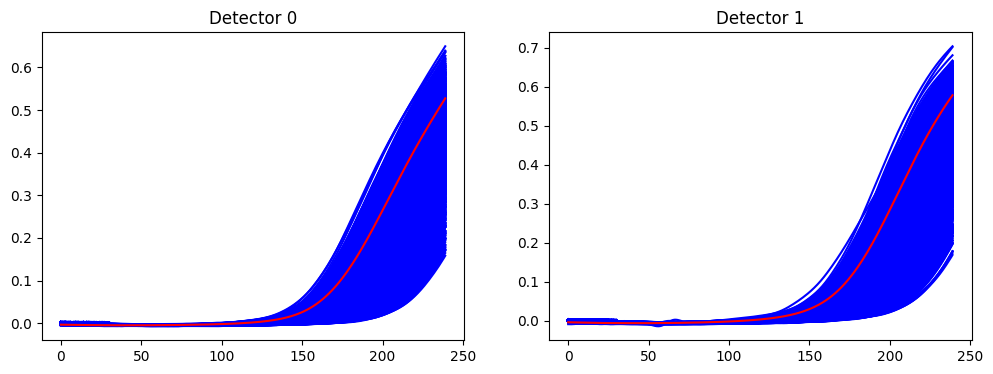

In [31]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.plot(mean_pulse_dec0[start:stop],'r-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.plot(mean_pulse_dec1[start:stop],'r-')
plt.title('Detector 1')

In [32]:
#--------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Train_dec1 = momentos(trainX_dec1)

#------------------------------------------ Normalize -------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)

#------------------------------------ Print Important information -----------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min detector 0: ', min_dec0)
print('Max detector 0: ', max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min detector 1: ', min_dec1)
print('Max detector 1: ', max_dec1)

(2211, 12, 2) NM = 12
Min detector 0:  0.0006360751722697374
Max detector 0:  32.6481239301956
(2211, 12, 2) NM = 12
Min detector 1:  -0.037926531094141215
Max detector 1:  35.30437343873747


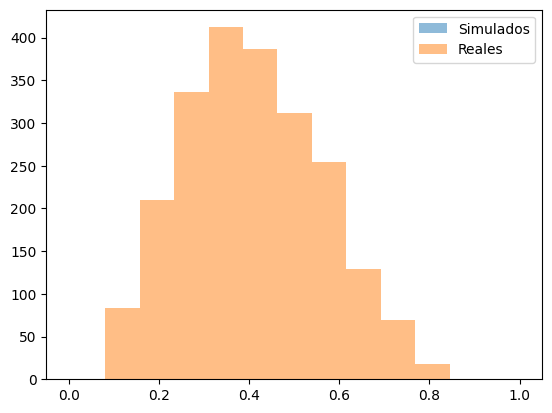

In [33]:
plt.hist(M_Train_dec0[:Num_casos,0,0], alpha = 0.5, label = 'Simulados');
plt.hist(M_Train_dec0[Num_casos:,0,0], alpha = 0.5, label = 'Reales');
plt.legend()

# **FULL TOF**

In [34]:
#-------------------------------------- Create Reference pulses set ----------------------------------------
REFERENCE_PULSE_dec0 = np.tile(new_V82[0,start:stop,:], (trainX_dec0.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V82[0,start:stop,:], (trainX_dec1.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)

M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1 - min_dec1)

In [35]:
#-------------------------------------------- Create test set -------------------------------------------------------------
#delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_V55, start = start, stop = stop, max_delay = 240, channel = 0)
#delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_V55, start = start, stop = stop, max_delay = 240, channel = 1)


#------------------------------- Create other positions ------------------------------------------------------------------
#new_V55 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
#new_V28 = create_position(new_V55, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
#new_V82 = create_position(new_V55, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)

new_V55 = new_V55[:,start:stop,:]
new_V28 = new_V28[:,start:stop,:]
new_V82 = new_V82[:,start:stop,:]



M_V55 = momentos(new_V55)
M_V55[:,:,0] = (M_V55[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V55[:,:,1] = (M_V55[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

M_V28 = momentos(new_V28)
M_V28[:,:,0] = (M_V28[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V28[:,:,1] = (M_V28[:,:,1] - min_dec1)/(max_dec1 - min_dec1)

M_V82 = momentos(new_V82)
M_V82[:,:,0] = (M_V82[:,:,0] - min_dec0)/(max_dec0 - min_dec0)
M_V82[:,:,1] = (M_V82[:,:,1] - min_dec1)/(max_dec1 - min_dec1)


In [47]:
epochs = 150
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

directory = '/home/josea/temporal/'


for i in range(num_semillas):

  model_dec0 = model_definition(NM = NM, NN = 32, STD_INIT = 0.5)
  model_dec1 = model_definition(NM = NM, NN = 32, STD_INIT = 0.5)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)

  model_dec0.compile(optimizer = opt_dec0, loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1, loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 1, batch_size = 512, shuffle = True, verbose = 1)
     history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 1, batch_size = 512, shuffle = True, verbose = 1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

    
     TOFN_dec0_REF_V82 = model_dec0.predict([M_V82[:,:,0],M_REF_dec0[:M_V82.shape[0],:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_V82[:,:,1],M_REF_dec1[:M_V82.shape[0],:,0]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_V55[:,:,0],M_REF_dec0[:M_V55.shape[0],:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_V55[:,:,1],M_REF_dec1[:M_V55.shape[0],:,0]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_V28[:,:,0],M_REF_dec0[:M_V28.shape[0],:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_V28[:,:,1],M_REF_dec1[:M_V28.shape[0],:,0]])
    
     #TOFN_V28 = (np.squeeze(TOFN_dec0_REF_V28) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V28) - new_time_step*delays_test_dec1)
     #TOFN_V55 = (np.squeeze(TOFN_dec0_REF_V55) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V55) - new_time_step*delays_test_dec1)
     #TOFN_V82 = (np.squeeze(TOFN_dec0_REF_V82) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V82) - new_time_step*delays_test_dec1)

     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
     centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '_' + str(epoch) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '_' + str(epoch) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.1120
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.4117
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 6.0077
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 6.1779
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 5.9146
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 6.0604
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

(array([3]), array([82])) 0.07594652622080596


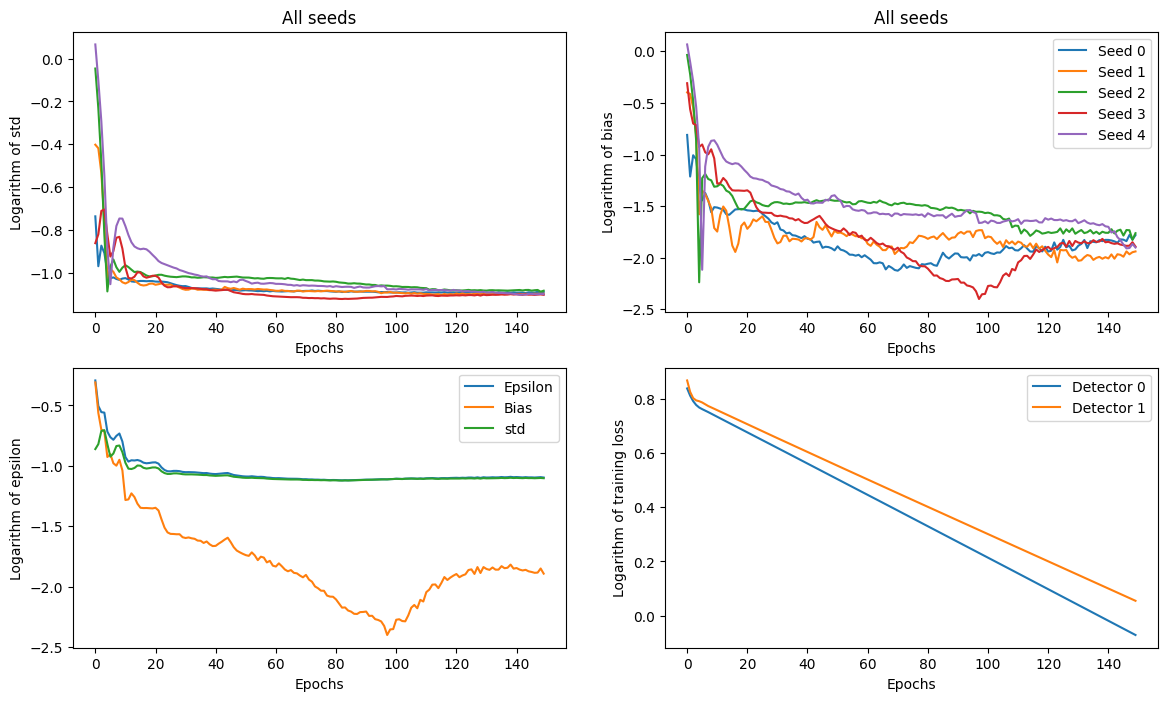

In [50]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 3
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of std')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  plt.plot(np.log10(bias[i,:]), label = label)
plt.legend()
plt.ylabel('Logarithm of bias')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]), label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.195  FWHM(ns) = 0.196  std(ns) = 0.083
V55: CENTROID(ns) = 0.007  FWHM(ns) = 0.186  std(ns) = 0.079
V28: CENTROID(ns) = -0.209  FWHM(ns) = 0.161  std(ns) = 0.068


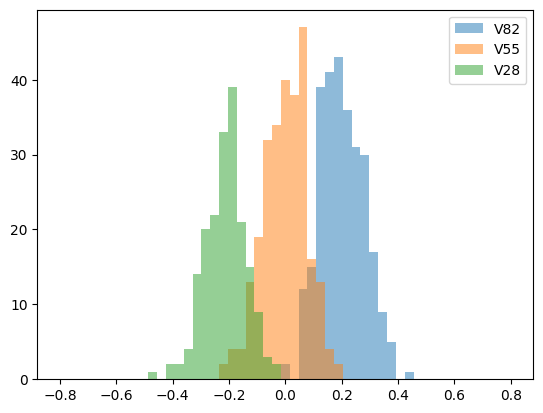

In [51]:
epoch = 82
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range = [-0.8,0.8],alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range = [-0.8,0.8],alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range = [-0.8,0.8],alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [52]:
Error_V82 = (TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) - 0.2)**2 
Error_V55 = (TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]))**2 
Error_V28 = (TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) + 0.2)**2 

Error = np.concatenate((Error_V82, Error_V55, Error_V28)) 
MSE = np.mean(Error)   
print(MSE)                                                                                                               

0.005826901988519145


# **ENSEMBLE MODEL**

In [53]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)


V82: CENTROID(ns) = 0.192  FWHM(ns) = 0.205  std(ns) = 0.087
V55: CENTROID(ns) = 0.005  FWHM(ns) = 0.193  std(ns) = 0.082
V28: CENTROID(ns) = -0.220  FWHM(ns) = 0.166  std(ns) = 0.071


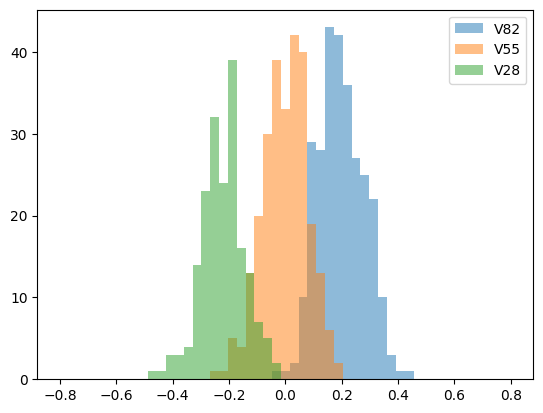

In [54]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_V82 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_V55 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_V28 - np.mean(weighted_mean_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))